# NEU-DET Surface Defect Image Classification

A quick practise of image classification.
The dataset is balenced image classification dataset.
There 1440 black and white images of 200x200 pixels in the training set and 360 in the validation set.
There are 6 classes of defects.


## Approaches
Since 200x200 pixels are relatively large input size, the tree-based models like XGBoost are not very suitable.
On the otherhand, this problem very much matches common use case of convolutional Resnet architectures, e.g, Resnet50.
Since the problem seems relatively easy, since we have only black and white images and only 6 classes in contrast to 1000 classes of colored images, we can try smaller model Resnet18.
Given the small size of the dataset, we likely have to start with a pretrained model, which is often speeds up the training convergence even in cases where we have sufficiently sized dataset.


## Solution Description
The input black and white.
We can simulate rgb by copying across the channels.
We could also average out the network, which could save resources, but it is not certain to succeed.

Since we are training a neural network, we have additional hyperparameters. Many of them can be set to some good defaults.
However, number of epochs usually differs a lot.
We can look out for overfitting and save training resources by using a validation set performance and using early stopping.
In this case only a manual early stopping is used.

Augmentations are used to increase generalization. These are turned off during the validation or testing phase to not affect the results.

## What to Be Careful About
- Always set model into the right mode.
- Always turn off the augmentations in evaluation mode.
- Do not introduce too strong augmentations that are beyond realistic.

## Results
The testing set accuracy is similar around 97%, much above above random classifier of 16%. The validation results for Epoch: 5  are around 97% too.

## Potential Improvements
- Hyperparameter tunning.
- Selection of the best train-time augmentations could effectively increase the training set size or increase robustness to distribution shift in the production. However incorrect augmentation can also worsen the performance.
- Early stoppping and the best model selection could be implemented.
- More powerful model could be used.


## [Follow Vaclav Kosar for more software and machine learning at https://vaclavkosar.com/](https://vaclavkosar.com/)


In [23]:
import os

train_files = []
for dirname, _, filenames in os.walk('/kaggle/input/neu-surface-defect-database/NEU-DET/train/'):
    for filename in filenames:
        if filename.endswith('.jpg'):
            file = os.path.join(dirname, filename)
            train_files.append(file)

print(len(train_files))
            
val_files = []
for dirname, _, filenames in os.walk('/kaggle/input/neu-surface-defect-database/NEU-DET/validation/'):
    for filename in filenames:
        if filename.endswith('.jpg'):
            file = os.path.join(dirname, filename)
            val_files.append(file)


print(len(val_files))

1440
360


In [24]:
!pip install pandas==2.0.3 Pillow==10.1.0 pytorch-ignite==0.4.13 albumentations==1.3.1 torch==2.0.0 torchvision==0.15.1 scikit-learn==1.2.2

In [25]:
import base64
import os
from glob import glob

import albumentations as A
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from IPython.core.display import HTML
from PIL import Image
from albumentations.pytorch import ToTensorV2 as ToTensor
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.resnet import resnet18

In [26]:
MODEL_BIN = 'pytorch_model.bin'

# convert names of the defects to categorical variable
label_name_to_label_id = {'in': 0, 'pi': 1, 'cr': 2, 'pa': 3, 'sc': 4, 'ro': 5}
label_id_to_label_name = {l_id: l_name for l_name, l_id in label_name_to_label_id.items()}


full_df = pd.DataFrame(dict(file=train_files + val_files))
full_df['label_name'] = full_df['file'].map(lambda file: os.path.basename(file)).str[:2].str.lower()

# print(full_df['label_name'].head())

full_df['label'] = full_df['label_name'].map(label_name_to_label_id)
# print(full_df[full_df['label'].isnull()].head())
assert full_df['label'].notnull().all()

In [27]:
full_df.sample(10).head(10)

,file,label_name,label
1759,/kaggle/input/neu-surface-defect-database/NEU-...,ro,5
226,/kaggle/input/neu-surface-defect-database/NEU-...,in,0
1055,/kaggle/input/neu-surface-defect-database/NEU-...,cr,2
381,/kaggle/input/neu-surface-defect-database/NEU-...,sc,4
1632,/kaggle/input/neu-surface-defect-database/NEU-...,pa,3
879,/kaggle/input/neu-surface-defect-database/NEU-...,pa,3
306,/kaggle/input/neu-surface-defect-database/NEU-...,sc,4
1682,/kaggle/input/neu-surface-defect-database/NEU-...,cr,2
1643,/kaggle/input/neu-surface-defect-database/NEU-...,pa,3
365,/kaggle/input/neu-surface-defect-database/NEU-...,sc,4


In [28]:
len(full_df)

1800

In [29]:
full_df['label_name'].value_counts()

label_name
in    300
sc    300
pi    300
pa    300
cr    300
ro    300
Name: count, dtype: int64

In [30]:
def image_formatter(img_file):
    with open(img_file, "rb") as f:
        encoded_string = base64.b64encode(f.read()).decode()
        return f'<img width="150" src="data:image/png;base64,{encoded_string}">'

def display_frame(df: pd.DataFrame):
    # displays images in HTML
    return display(
        HTML(
            df.to_html(
                formatters={
                    'file': image_formatter,
                },
                escape=False,
                index=True,
            )
        )
    )

,file,label_name,label
1417,,ro,5
1684,,cr,2
842,,pa,3
1666,,pa,3
1335,,ro,5

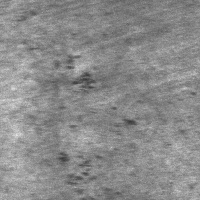
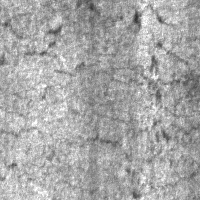
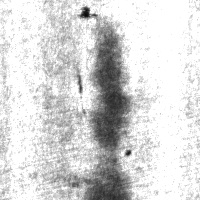
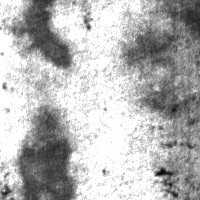
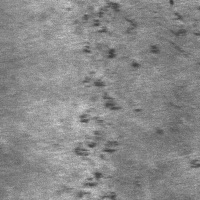

In [31]:
display_frame(full_df.sample(5))

In [32]:
train_df = full_df[:len(train_files)]
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=4242)
test_df = full_df[len(train_files):].copy()

In [33]:
# inspiration https://github.com/pytorch/ignite/blob/master/examples/references/classification/imagenet/configs/train/baseline_resnet50.py
batch_size = 64  # total batch size
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# train_crop_size = 224
# val_crop_size = 320

# from torchvision import transforms as transforms
# from torchvision.transforms import v2 as transforms
# from torchvision.transforms.v2 import Resize

# train_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
# #     transforms.Resize((200, 200)),
# #     transforms.Normalize(mean=mean, std=std),
#     transforms.PILToTensor(),
# ])
    
    
# Augmentations to "increase amount of data"
train_transforms = A.Compose(
    [
        A.Resize(224, 224),
        
        # Randomly resizes and then crops the image. Commented out as you have Resize to 224x224 right after.
         A.RandomResizedCrop(height=224, width=224, scale=(0.08, 1.0)),
        
        # Random brightness/contrast to simulate different lighting conditions.
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        
        # Randomly flips the input image horizontally with a given probability.
        A.HorizontalFlip(p=0.5),
        
        
        A.CoarseDropout(max_height=32, max_width=32),
        # A.HueSaturationValue(),
        
        # Affine transformations can simulate camera angle changes and perspective shifts.
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),
        
        # Optical distortions can simulate imperfections in camera lenses.
        A.OpticalDistortion(distort_limit=0.1, shift_limit=0.1, p=0.5),
        
        # Noise can simulate graininess in images.
        A.GaussNoise(var_limit=(10, 50), p=0.5),
        
        A.Normalize(mean=mean, std=std),
        ToTensor(),
    ]
)



# Could use different val transforms
val_transforms = A.Compose(
    [
        # https://github.com/facebookresearch/FixRes/blob/b27575208a7c48a3a6e0fa9efb57baa4021d1305/imnet_resnet50_scratch/transforms.py#L76
        A.Resize(224, 224),
        # A.CenterCrop(val_crop_size, val_crop_size),
        A.Normalize(mean=mean, std=std),
        ToTensor(),
    ]
)


class NEUDataset(Dataset):
    def __init__(self, df, dataset_transforms):
        self.df = df
        self.dataset_transforms = dataset_transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file, label = self.df[['file', 'label']].iloc[idx].values

        # category = np.array(label).astype(np.float32)
        # category = np.array(label)
        category = torch.as_tensor(label)

        img = np.array(Image.open(file))
#         img = np.repeat(img[..., np.newaxis], 3, -1)
        img = self.dataset_transforms(image=img)['image']
#         img = train_transforms(img)
#         img = img.transpose((2, 0, 1))
        return img, category


train_ds = NEUDataset(train_df, train_transforms)
val_ds = NEUDataset(val_df, val_transforms)
test_ds = NEUDataset(test_df, val_transforms)

num_workers = 0
train_loader = DataLoader(train_ds, shuffle=True, batch_size=batch_size, num_workers=num_workers)
val_loader = DataLoader(val_ds, shuffle=False, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_ds, shuffle=False, batch_size=batch_size, num_workers=num_workers)

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class NeuClassifier(nn.Module):

    def __init__(self, n_classes: int, device='cpu'):
        super(NeuClassifier, self).__init__()

        self.device = device

        # Docs https://pytorch.org/vision/master/models/generated/torchvision.models.resnet18.html
        self.resnet = resnet18(pretrained=True)

        self.backbone = create_feature_extractor(self.resnet, return_nodes=["avgpool"])
        self.backbone.to(device)
        self.post = nn.Linear(in_features=512, out_features=n_classes)
        self.post.to(device)

    def forward(self, image):
        x = self.backbone(image.to(self.device))
        x = x["avgpool"]
        x = torch.squeeze(torch.squeeze(x, axis=2), axis=2)
        x = self.post(x)

        # TODO dropout during training
        return torch.nn.functional.log_softmax(x, dim=-1)

    def to_disk(self, local_model_dir: str) -> None:
        torch.save(self.state_dict(), local_model_dir + MODEL_BIN, pickle_protocol=4)

    @classmethod
    def from_disk(cls, local_model_dir: str, n_classes: int, device: str):
        state_dict = torch.load(local_model_dir + MODEL_BIN, map_location=device)
        model = cls(n_classes, device)
        model.load_state_dict(state_dict, strict=True)
        return model

In [35]:
# Setup Training

num_epochs = 105

criterion = nn.CrossEntropyLoss()


model = NeuClassifier(n_classes=len(label_name_to_label_id), device=device)

le = len(train_loader)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007, weight_decay=1e-4)  # lr should be kept low so that the pre-trained weights don't change easily


# SGD Variant
# base_lr = 0.1 * (batch_size / 256.0)
# lr_scheduler = lrs.MultiStepLR(optimizer, milestones=[30 * le, 60 * le, 90 * le, 100 * le], gamma=0.1)
# optimizer = optim.SGD(model.parameters(), lr=base_lr, momentum=0.9, weight_decay=1e-4)

trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

val_metrics = {
    "accuracy": Accuracy(),
    "nll": Loss(criterion)
}
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)

@trainer.on(Events.ITERATION_COMPLETED(every=10))
def log_training_loss(trainer):
    print(f"Epoch[{trainer.state.epoch}] Loss: {trainer.state.output:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    print(f"Training Results - Epoch: {trainer.state.epoch}  Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['nll']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print(f"Validation Results - Epoch: {trainer.state.epoch}  Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['nll']:.2f}")

trainer.run(train_loader, max_epochs=5, seed=333)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/ignite/engine/engine.py:836: UserWarning: Argument seed is deprecated. It will be removed in 0.4.14. Please, use torch.manual_seed or ignite.utils.manual_seed
  warnings.warn(


Epoch[1] Loss: 0.42
Training Results - Epoch: 1  Avg accuracy: 0.60 Avg loss: 3.00
Validation Results - Epoch: 1  Avg accuracy: 0.68 Avg loss: 3.43
Epoch[2] Loss: 0.47
Epoch[2] Loss: 0.39
Training Results - Epoch: 2  Avg accuracy: 0.84 Avg loss: 0.64
Validation Results - Epoch: 2  Avg accuracy: 0.97 Avg loss: 0.23
Epoch[3] Loss: 0.51
Epoch[3] Loss: 0.45
Training Results - Epoch: 3  Avg accuracy: 0.72 Avg loss: 2.29
Validation Results - Epoch: 3  Avg accuracy: 0.75 Avg loss: 1.86
Epoch[4] Loss: 0.37
Epoch[4] Loss: 0.42
Training Results - Epoch: 4  Avg accuracy: 0.88 Avg loss: 0.35
Validation Results - Epoch: 4  Avg accuracy: 0.97 Avg loss: 0.15
Epoch[5] Loss: 0.28
Epoch[5] Loss: 0.22
Training Results - Epoch: 5  Avg accuracy: 0.94 Avg loss: 0.18
Validation Results - Epoch: 5  Avg accuracy: 0.97 Avg loss: 0.10


State:
	iteration: 90
	epoch: 5
	epoch_length: 18
	max_epochs: 5
	output: 0.22321228682994843
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [36]:
evaluator.run(test_loader)
metrics = evaluator.state.metrics
print(f"Test Results - Epoch: {trainer.state.epoch}  Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['nll']:.2f}")
model.to_disk('/kaggle/working/')

Test Results - Epoch: 5  Avg accuracy: 0.97 Avg loss: 0.11


In [37]:
# Load model from disk
model = NeuClassifier.from_disk('/kaggle/working/', n_classes=len(label_name_to_label_id), device=device)
model.eval()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NeuClassifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [38]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
# images, labels = dataiter.next()
pred_arr = []
pred_name_arr = []

# iterating on the dataset to predict the output
for batch in test_loader:
    images, labels = batch
    predictions = torch.exp(model(images))
    predictions = predictions.to('cpu').detach().numpy().squeeze()
    pred_ids = np.argmax(predictions, -1)
    for pred_id in pred_ids:
        pred_arr.append(pred_id)
        pred_name_arr.append(label_id_to_label_name[pred_id])

test_df['prediction_name'] = pred_name_arr
test_df['prediction'] = pred_arr

In [39]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_df['label'], test_df['prediction'])
print(f'accuracy: {accuracy}')


from sklearn.metrics import precision_recall_fscore_support


precision, recall, f1_score, support = precision_recall_fscore_support(test_df['label'], test_df['prediction'])
print(f'precision: {precision}, recall {recall}, f1_score: {f1_score}, support: {support}')


accuracy: 0.9694444444444444
precision: [1.         0.87878788 0.98360656 0.98360656 1.         0.98275862], recall [0.9        0.96666667 1.         1.         1.         0.95      ], f1_score: [0.94736842 0.92063492 0.99173554 0.99173554 1.         0.96610169], support: [60 60 60 60 60 60]


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

,file,label_name,label,prediction_name,prediction
1511,,sc,4,sc,4
1627,,pa,3,pa,3
1567,,pi,1,pi,1
1675,,pa,3,pa,3
1456,,in,0,in,0
1509,,sc,4,sc,4
1720,,cr,2,cr,2
1544,,sc,4,sc,4
1497,,in,0,in,0
1525,,sc,4,sc,4

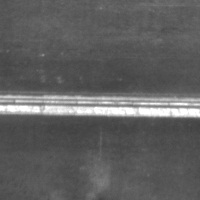
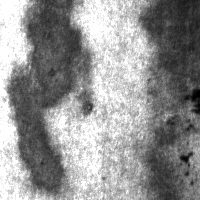
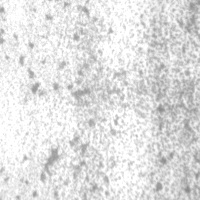
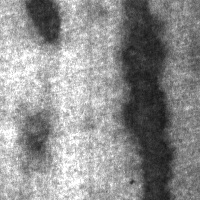
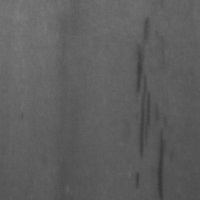
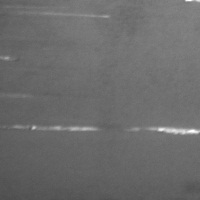
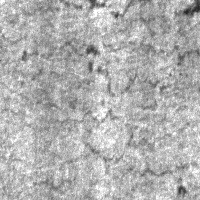
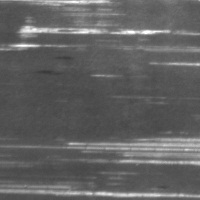
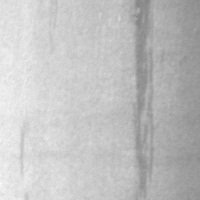
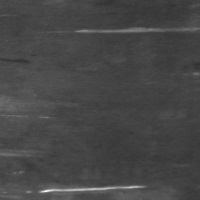
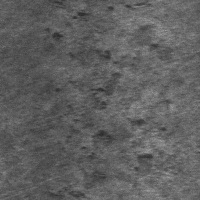
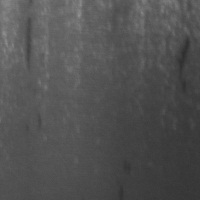
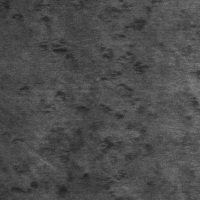
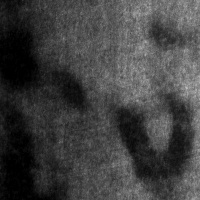
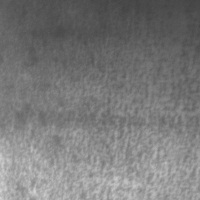
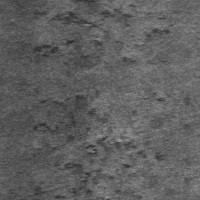
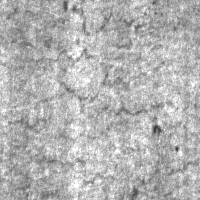
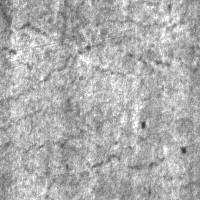
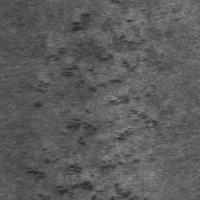
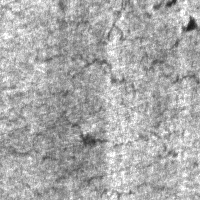
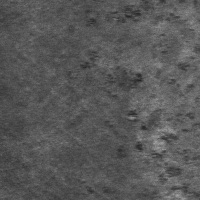
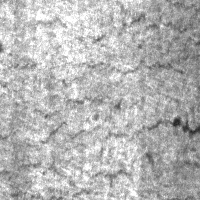
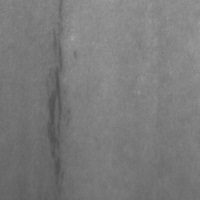
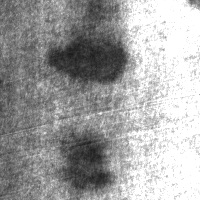
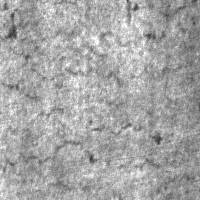
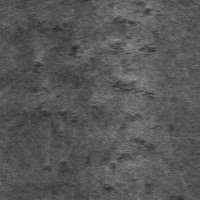
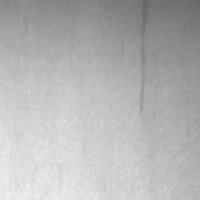
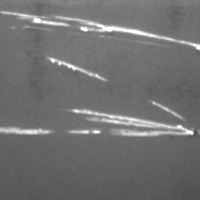
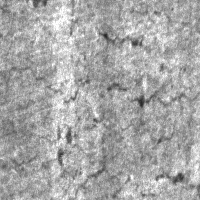
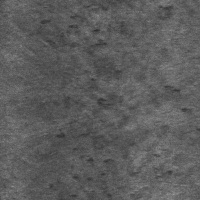

In [40]:

display_frame(test_df.sample(30))

In [41]:
print((test_df['label'] != test_df['prediction']).sum())
confusion_matrix(test_df['label'], test_df['prediction'])

11


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

array([[54,  5,  0,  1,  0,  0],
       [ 0, 58,  1,  0,  0,  1],
       [ 0,  0, 60,  0,  0,  0],
       [ 0,  0,  0, 60,  0,  0],
       [ 0,  0,  0,  0, 60,  0],
       [ 0,  3,  0,  0,  0, 57]])